# Introduction to Sionna RT

In this notebook, you will

- Discover the basic functionalities of Sionna's [ray tracing (RT) module](https://nvlabs.github.io/sionna/api/rt.html)
- Learn how to compute coverage maps
- Use ray-traced channels for link-level simulations instead of stochastic channel models


## Table of Contents
* [Background Information](#Background-Information)
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Loading Scenes](#Loading-Scenes)
* [Ray Tracing for Radio Propagation](#Ray-Tracing-for-Radio-Propagation)
* [From Paths to Channel Impulse Responses](#From-Paths-to-Channel-Impulse-Responses)
* [BER Evaluation](#BER-Evaluation)
* [Runtime vs Depth](#Runtime-vs-Depth)
* [Coverage Map](#Coverage-Map)
* [Site-specifc Link-Level Simulations](#Site-specifc-Link-Level-Simulations)
* [Conclusion and Outlook](#Conclusion-and-Outlook)

## Background Information

Ray tracing is a technique to simulate environment-specific and physically accurate channel realizations for a given scene and user position.
Please see the [EM Primer](https://nvlabs.github.io/sionna/em_primer.html) for further details on the theoretical background of ray tracing of wireless channels.

Sionna RT is a ray tracing extension for radio propagation modeling which is built on top of [Mitsuba 3](https://www.mitsuba-renderer.org/) and [TensorFlow](https://www.tensorflow.org/). Like all of Sionna's components, it is differentiable.

Mitsuba 3 is a rendering system for forward and inverse light-transport simulation that makes use of the differentiable just-in-time compiler [Dr.Jit](https://drjit.readthedocs.io/en/latest/).
Sionna RT relies on Mitsuba 3 for the rendering and handling of scenes, e.g., its XML-file format, as well as the computation of ray intersections with scene primitives, i.e., triangles forming a mesh. The transformations of the polarized field components at each point of interaction between a ray and a scene object, e.g., reflection, are computed in TensorFlow, which is also used to combine the retained paths into (optionally) time-varying channel impulse responses. Thanks to TensorFlow's automatic gradient computation, channel impulse responses and functions thereof are differentiable with respect to most parameters of the ray tracing process, including material properties (conductivity, permittivity), antenna patterns, orientations, and positions.

Scene files for Mitsuba 3 can be created, edited, and exported with the popular open-source 3D creation suite [Blender](https://www.blender.org/) and the [Mitsuba-Blender add-on](https://github.com/mitsuba-renderer/mitsuba-blender). One can rapdily create scenes from almost any place in the world using [OpenStreetMap](https://www.openstreetmap.org/) and the [Blender-OSM add-on](https://prochitecture.gumroad.com/l/blender-osm). In Sionna, scenes and radio propagation paths can be either rendered through the lens of configurable cameras via ray tracing or displayed with an integrated 3D viewer. For more detail on scene creation and rendering, we refer to [Sionna's API documentation](https://nvlabs.github.io/sionna/api/rt.html) and the available [video tutorial](https://youtu.be/7xHLDxUaQ7c).


## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [ ]:
import os # Configure which GPU 
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we 
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = False # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

## Loading Scenes

The Sionna RT module can either load external scene files (in Mitsuba's XML file format) or it can load one of the [integrated scenes](https://nvlabs.github.io/sionna/api/rt.html#example-scenes).

In this example, we load an example scene containing the area around the Frauenkirche in Munich, Germany.

In [3]:
# Load integrated scene

# scene_path = os.path.expanduser("~/workarea/geometry-extraction/scenes/simple/simple_scene_4cubes/simple_scene_4cubes.xml")
scene_path = os.path.expanduser("~/workarea/geometry-extraction/scenes/simple/simple_scene_4cubes_1reflector/simple_scene_4cubes_1reflector.xml")

scene = load_scene(scene_path)


To visualize the scene, we can use the `preview` function which opens an interactive preview of the scene.
This only works in Jupyter notebooks.

You can use the following controls:

- Mouse left: Rotate
- Scroll wheel: Zoom
- Mouse right: Move

Please note that the preview does not work in Colab and is therefore deactivated when `colab_compat` is set to True.
Further, only one preview instance can be open at the same time.

In [4]:
# Render scene
if no_preview:
    scene.render(camera="scene-cam-0", num_samples=1024);

In [5]:
%%skip_if no_preview
# Open 3D preview (only works in Jupyter notebook)
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

It is often convenient to choose a viewpoint in the 3D preview prior to rendering it as a high-quality image.
The next cell uses the "preview" camera which corresponds to the viewpoint of the current preview image.

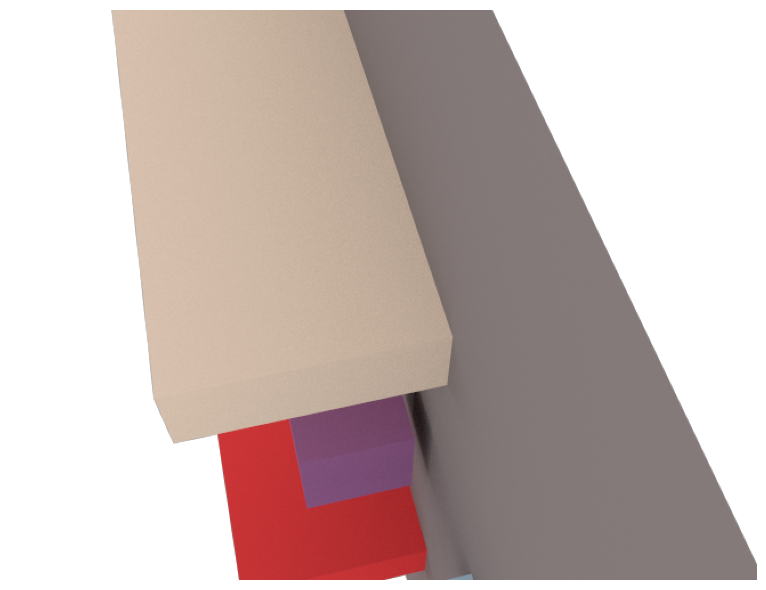

In [6]:
# The preview camera can be directly rendered as high-quality image
if not no_preview:
    scene.render(camera="preview", num_samples=512);
else:
    print("Function not available in Colab mode.")

One can also render the image to a file as shown below:

In [7]:
render_to_file = False # Set to True to render image to file

# Render scene to file from preview viewpoint
if render_to_file:
    scene.render_to_file(camera="scene-cam-0", # Also try camera="preview"
                         filename="scene.png",
                         resolution=[650,500])

Instead of the preview camera, one can also specify dedicated cameras with different positions and `look_at` directions.

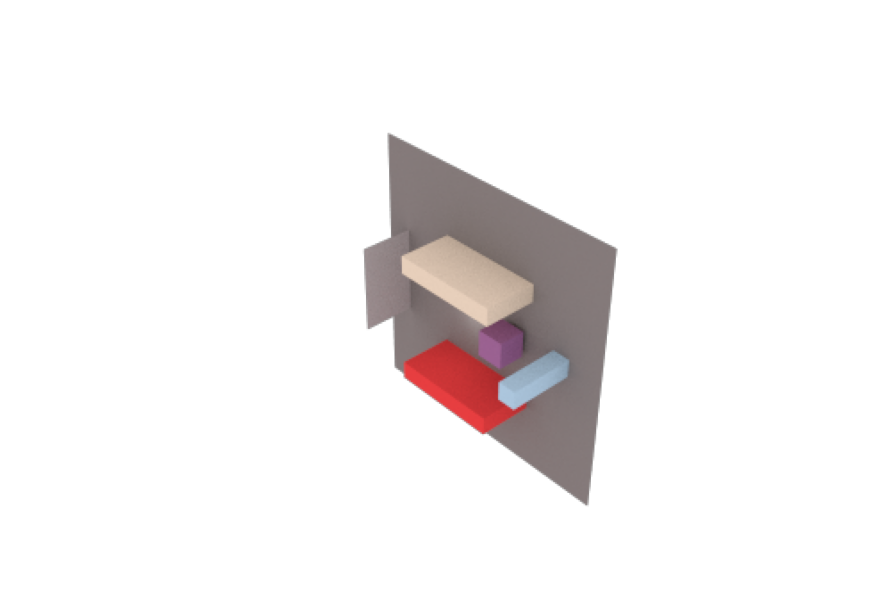

In [8]:
# Create new camera with different configuration
my_cam = Camera("my_cam", position=[-150,150,150], look_at=[-15,30,28])
scene.add(my_cam)

# Render scene with new camera*
scene.render("my_cam", resolution=resolution, num_samples=512); # Increase num_samples to increase image quality

Note that each [SceneObject](https://nvlabs.github.io/sionna/api/rt.html#scene-objects) (camera, transmitter,...) needs a unique name. Thus, running the cells above multiple times will lead to an error if the object name is not changed or the object is not removed from the scene.

## Ray Tracing for Radio Propagation

We need to configure transmitters and receivers prior to computing propagation paths between them. All transmitters and all receivers are equipped with the same antenna arrays which are defined by the `scene` properties `scene.tx_array` and `scene.rx_array`, respectively. Antenna arrays are composed of multiple identical antennas. Antennas can have custom or pre-defined patterns and are either single- or dual-polarized. One can add multiple transmitters and receivers to a scene which need to have unique names, a position, and orientation which is defined by yaw, pitch, and roll angles. 

In [9]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",  # "tr38901"
                             polarization="cross")  # "cross"

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",  # "dipole"
                             polarization="cross")  # "V"

# Create transmitter
tx = Transmitter(name="tx",
                 position=[-22.5,18,0],  # NOTE: Y and Z are flipped compared to blender scene
                 )  # power_dbm=50
 

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[25,0,0],
              orientation=[0,0,0],
              look_at = tx)

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver

Each [SceneObject](https://nvlabs.github.io/sionna/api/rt.html#scene-objects) has an assigned [RadioMaterial](https://nvlabs.github.io/sionna/api/rt.html#radio-materials) that describes the electromagnetic properties of the object whenever it interacts with a ray.
This behavior can be frequency-dependent and the ray tracing is done for a specific frequency.

We now set the carrier frequency of the scene and implicitly update all RadioMaterials.

In [10]:
scene.frequency = 3.5e9 # in Hz; implicitly updates RadioMaterials  # 3.5e9 # 2.14e9

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

The default scenes have RadioMaterials assigned to each scene object. However, the RadioMaterial of a specific object can be modified and customized by the user.

In [11]:
# Select an example object from the scene

print(f"len(scene.objects) = {len(scene.objects)}")
print(scene.objects)
for i, obj in enumerate(scene.objects.values()):
    print(f"{obj.name} : {obj.radio_material.name}")  # NOTE: {obj.scene.center} => shows same centers for all objects in scene
    if i >= 10:
        break

so = scene.get("elm__3")

# Print name of assigned radio material for different frequenies
for f in [3.5e9]: # Print for differrent frequencies  # [3.5e9, 2.14e9]
    scene.frequency = f
    print(f"\nRadioMaterial: {so.radio_material.name} @ {scene.frequency/1e9:.2f}GHz")
    print("Conductivity:", so.radio_material.conductivity.numpy())
    print("Relative permittivity:", so.radio_material.relative_permittivity.numpy())
    print("Complex relative permittivity:", so.radio_material.complex_relative_permittivity.numpy())
    print("Relative permeability:", so.radio_material.relative_permeability.numpy())
    print("Scattering coefficient:", so.radio_material.scattering_coefficient.numpy())
    print("XPD coefficient:", so.radio_material.xpd_coefficient.numpy())

len(scene.objects) = 6
{'elm__3': <sionna.rt.scene_object.SceneObject object at 0x7b3c5338a650>, 'elm__7': <sionna.rt.scene_object.SceneObject object at 0x7b3c80d31060>, 'elm__9': <sionna.rt.scene_object.SceneObject object at 0x7b3d24f21390>, 'elm__11': <sionna.rt.scene_object.SceneObject object at 0x7b3c600723b0>, 'elm__13': <sionna.rt.scene_object.SceneObject object at 0x7b3d201bd330>, 'elm__15': <sionna.rt.scene_object.SceneObject object at 0x7b3d201be6b0>}
elm__3 : itu_concrete
elm__7 : itu_marble
elm__9 : itu_glass
elm__11 : itu_brick
elm__13 : itu_very_dry_ground
elm__15 : itu_metal

RadioMaterial: itu_concrete @ 3.50GHz
Conductivity: 0.123086944
Relative permittivity: 5.24
Complex relative permittivity: (5.24-0.63214296j)
Relative permeability: 1.0
Scattering coefficient: 0.0
XPD coefficient: 0.0


Let us run the ray tracing process and compute propagation paths between all transmitters and receivers. The parameter `max_depth` determines the maximum number of interactions between a ray and a scene objects. 
For example, with a `max_depth` of one, only LoS paths are considered. When the property `scene.synthetic_array` is set to `False`, antenna arrays are explicitly modeled by finding paths between any pair of transmitting and receiving antennas in the scene. Otherwise, arrays are represented by a single antenna located in the center of the array.
Phase shifts related to the relative antenna positions will then be applied based on a plane-wave assumption when the channel impulse responses are computed.

In [12]:
# Compute propagation paths
paths = scene.compute_paths(max_depth=5,
                            num_samples=1e6)  # Number of rays shot into directions defined
                                              # by a Fibonacci sphere , too few rays can
                                              # lead to missing paths

# Visualize paths in the scene
if no_preview:
    scene.render("my_cam", paths=paths, show_devices=True, show_paths=True, resolution=resolution);

In [13]:
%%skip_if no_preview
scene.preview(paths, show_devices=True, show_paths=True) # Use the mouse to focus on the visualized paths

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

*Remark*: only one preview instance can be opened at the same time. Please check the previous preview if no output appears.

The [Paths](https://nvlabs.github.io/sionna/api/rt.html#paths) object contains all paths that have been found between transmitters and receivers.
In principle, the existence of each path is determininistic for a given position and environment. Please note that due to the stochastic nature of the *shoot-and-bounce* algorithm, different runs of the `compute_paths` function can lead to different paths that are found. Most importantly, diffusely reflected or scattered paths are obtained through random sampling of directions after each interaction with a scene object. You can seet TensorFlow's random seed to a specific value before executing ``compute_paths`` to ensure reproducibility.

The Paths object contains detailed information about every found path and allows us to generated channel impulse responses and apply Doppler shifts for the simulation of time evolution.

Let us now inspect some of the available properties:

In [14]:
# Show the coordinates of the starting points of all rays.
# These coincide with the location of the transmitters.
print("Source coordinates: ", paths.sources.numpy())
print("Transmitter coordinates: ", list(scene.transmitters.values())[0].position.numpy())

# Show the coordinates of the endpoints of all rays.
# These coincide with the location of the receivers.
print("Target coordinates: ",paths.targets.numpy())
print("Receiver coordinates: ",list(scene.receivers.values())[0].position.numpy())

# Show the types of all paths:
# 0 - LoS, 1 - Reflected, 2 - Diffracted, 3 - Scattered
# Note that Diffraction and scattering are turned off by default.
print("Path types: ", paths.types.numpy())

Source coordinates:  [[-22.5  18.    0. ]]
Transmitter coordinates:  [-22.5  18.    0. ]
Target coordinates:  [[25.  0.  0.]]
Receiver coordinates:  [25.  0.  0.]
Path types:  [[0 1 1 1 1 1 1 1 1 1]]


We can see from the list of path types, that there are 14 paths in total. One LoS and 13 reflected paths.

In [15]:
# We can now access for every path the channel coefficient, the propagation delay,
# as well as the angles of departure and arrival, respectively (zenith and azimuth).

# Let us inspect a specific path in detail 
path_idx = 1 # Try out other values in the range [0, 13]
print(f"paths.a shape = {paths.a.shape}")

# For a detailed overview of the dimensions of all properties, have a look at the API documentation
print(f"\n--- Detailed results for path {path_idx} ---")
print(f"Channel coefficient: {paths.a[0,0,0,0,0,path_idx, 0].numpy()}")
print(f"Propagation delay: {paths.tau[0,0,0,path_idx].numpy()*1e6:.5f} us")
print(f"Zenith angle of departure: {paths.theta_t[0,0,0,path_idx]:.4f} rad")
print(f"Azimuth angle of departure: {paths.phi_t[0,0,0,path_idx]:.4f} rad")
print(f"Zenith angle of arrival: {paths.theta_r[0,0,0,path_idx]:.4f} rad")
print(f"Azimuth angle of arrival: {paths.phi_r[0,0,0,path_idx]:.4f} rad")

paths.a shape = (1, 1, 2, 1, 2, 10, 1)

--- Detailed results for path 1 ---
Channel coefficient: (4.234350853948854e-05-2.696852334338473e-06j)
Propagation delay: 0.01941 us
Zenith angle of departure: 1.1134 rad
Azimuth angle of departure: -0.3622 rad
Zenith angle of arrival: 1.1134 rad
Azimuth angle of arrival: 2.7794 rad


## From Paths to Channel Impulse Responses

Once paths are computed, they can be transformed into channel impulse responses (CIRs).
The class method [apply_doppler](https://nvlabs.github.io/sionna/api/rt.html#Paths.apply_doppler) can simulate time evolution of the CIR based on arbitrary velocity vectors of all transmitters and receivers for a desired sampling frequency and number of time steps. 
The class method [cir](https://nvlabs.github.io/sionna/api/rt.html#Paths.cir) generates the channel impulse responses which can be used by other components for link-level simulations in either time or frequency domains. The method also allows you to only consider certain types of paths, e.g., line-of-sight, reflections, etc.

In [16]:
# Default parameters in the PUSCHConfig
subcarrier_spacing = 15e3
fft_size = 48

In [17]:
# Print shape of channel coefficients before the application of Doppler shifts
# The last dimension corresponds to the number of time steps which defaults to one
# as there is no mobility
print("Shape of `a` before applying Doppler shifts: ", paths.a.shape)

# Apply Doppler shifts
paths.apply_doppler(sampling_frequency=subcarrier_spacing, # Set to 15e3 Hz
                    num_time_steps=14, # Number of OFDM symbols
                    tx_velocities=[3.,0,0], # We can set additional tx speeds
                    rx_velocities=[0,7.,0]) # Or rx speeds

print("Shape of `a` after applying Doppler shifts: ", paths.a.shape)

a, tau = paths.cir()
print("Shape of tau: ", tau.shape)

tau_full = tau

Shape of `a` before applying Doppler shifts:  (1, 1, 2, 1, 2, 10, 1)
Shape of `a` after applying Doppler shifts:  (1, 1, 2, 1, 2, 10, 14)
Shape of tau:  (1, 1, 1, 10)


Let us have a look at the channel impulse response for the 14 incoming paths from the simulation above.

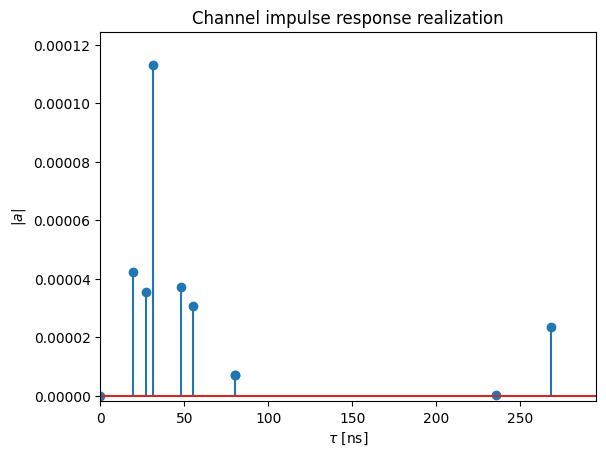

In [18]:
t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

Note that the delay of the first arriving path is normalized to zero. This behavior can be changed using the Paths' call property ``normalize_delays``. For link-level simulations, it is recommended to work with normalized delays, unless perfect synchronization is explicitly desired.

In [19]:
# Disable normalization of delays
paths.normalize_delays = False

# Get only the LoS path
_, tau = paths.cir(los=True, reflection=False)
print("Delay of first path without normalization: ", np.squeeze(tau))

paths.normalize_delays = True
_, tau = paths.cir(los=True, reflection=False)
print("Delay of first path with normalization: ", np.squeeze(tau))

Delay of first path without normalization:  1.6943777e-07
Delay of first path with normalization:  0.0


The CIRs can now be loaded either in the time-domain or frequency-domain channel models, respectively.
Please see [cir_to_ofdm_channel](https://nvlabs.github.io/sionna/api/channel.wireless.html#sionna.channel.cir_to_ofdm_channel) and [cir_to_time_channel](https://nvlabs.github.io/sionna/api/channel.wireless.html#sionna.channel.cir_to_time_channel) for further details.

In [20]:
# Compute frequencies of subcarriers and center around carrier frequency
frequencies = subcarrier_frequencies(fft_size, subcarrier_spacing)

print(f"frequencies shape = {frequencies.shape}")
print(f"a shape = {a.shape}")
print(f"tau shape = {tau_full.shape}")

# Compute the frequency response of the channel at frequencies.
h_freq = cir_to_ofdm_channel(frequencies,
                             a,
                             tau_full,  # originally only tau
                             normalize=True) # Non-normalized includes path-loss

# Verify that the channel power is normalized
h_avg_power = tf.reduce_mean(tf.abs(h_freq)**2).numpy()

print("Shape of h_freq: ", h_freq.shape)
print("Average power h_freq: ", h_avg_power) # Channel is normalized

frequencies shape = (48,)
a shape = (1, 1, 2, 1, 2, 10, 14)
tau shape = (1, 1, 1, 10)
Shape of h_freq:  (1, 1, 2, 1, 2, 14, 48)
Average power h_freq:  0.9999999


The frequency responses `h_freq` are now ready to be processed by the [ApplyOFDMChannel](https://nvlabs.github.io/sionna/api/channel.wireless.html#sionna.channel.ApplyOFDMChannel) Layer.

In [21]:
# Placeholder for tx signal of shape
# [batch size, num_tx, num_tx_ant, num_ofdm_symbols, fft_size]
x = tf.zeros([h_freq.shape.as_list()[i] for i in [0,3,4,5,6]], tf.complex64)

no = 0.1 # noise variance

# Init channel layer
channel = ApplyOFDMChannel(add_awgn=True)

# Apply channel
y = channel([x, h_freq, no])

# [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size]
print(y.shape)

(1, 1, 2, 14, 48)


## BER Evaluation
We now initialize a transmitter and receiver from the [5G NR PUSCH Tutorial](https://nvlabs.github.io/sionna/examples/5G_NR_PUSCH.html) notebook.
These components could be replaced by your own transceiver implementations.
Then we simulate PUSCH transmissions over the ray-traced CIRs that we generated in the previous cells.

In [22]:
# Init pusch_transmitter
pusch_config = PUSCHConfig()

# Instantiate a PUSCHTransmitter from the PUSCHConfig
pusch_transmitter = PUSCHTransmitter(pusch_config)

# Create a PUSCHReceiver using the PUSCHTransmitter
pusch_receiver = PUSCHReceiver(pusch_transmitter)

In [23]:
# Simulate transmissions over the
batch_size = 100 # h_freq is broadcast, i.e., same CIR for all samples but different AWGN realizations
ebno_db = 2. # SNR in dB

no = ebnodb2no(ebno_db,
               pusch_transmitter._num_bits_per_symbol,
               pusch_transmitter._target_coderate,
               pusch_transmitter.resource_grid)

x, b = pusch_transmitter(batch_size) # Generate transmit signal and info bits

y = channel([x, h_freq, no]) # Simulate channel output

b_hat = pusch_receiver([y, no]) # Recover the info bits

# Compute BER
print(f"BER: {compute_ber(b, b_hat).numpy():.5f}")

BER: 0.00000


**Remark** Contrary to other Sionna components, ray tracing does not have a dedicated batch dimension.
However, multiple transmitter and receivers can be simulated in parallel, which effectively equals a batch-dimension.

Note that simulating multiple receivers in the ray tracer comes at little additional overhead.
However, the complexity increases significantly for multiple transmitters as an individual ray tracing step is required for each transmitter.
As the total number of rays is fixed, an increased number of transmitter requires also an increased number of rays in the `compute_paths` step for the same overall precision.

## Runtime vs Depth

We will now investigate the complexity of the ray tracing algorithm for different values of `max_depth`, i.e., for a different number of bounces of the rays.

In [24]:
max_depths = 10 # evaluate performance up to 10 reflections
depths = range(1,max_depths+1)
ts = []
pl_avg = []
for d in depths:
    # save start time
    t = time.time()
    # run the ray tracer
    paths = scene.compute_paths(max_depth=d)
    # and measure the required time interval
    ts.append(time.time()-t)

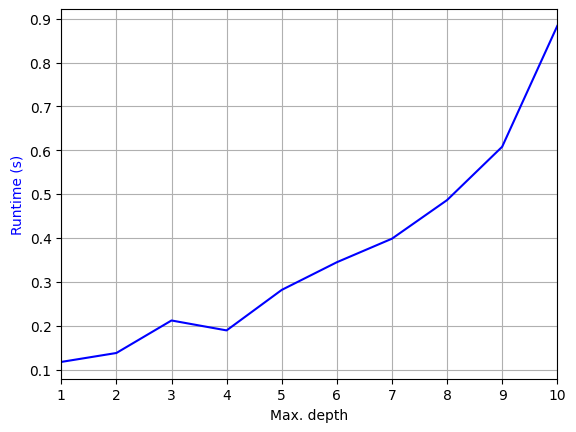

In [25]:
# and plot results
plt.figure()
plt.plot(depths, ts, color="b");
plt.xlabel("Max. depth")
plt.ylabel("Runtime (s)", color="b")
plt.grid(which="both")
plt.xlim([1, max_depths]);

As can be seen, the computational complexity increases significantly with the number of ray interactions. Note that the code above does not account for scattering or diffraction. Adding these phenomea adds additional complexity as can be seen below:

In [26]:
t = time.time()
paths = scene.compute_paths(max_depth=3, diffraction=False)
print("Time without diffraction and scattering:" , time.time()-t)

t = time.time()
paths = scene.compute_paths(max_depth=3, diffraction=True)
print("Time with diffraction:" , time.time()-t)

t = time.time()
paths = scene.compute_paths(max_depth=3, scattering=True)
print("Time with scattering:" , time.time()-t)

Time without diffraction and scattering: 0.18962693214416504
Time with diffraction: 0.25208544731140137
Time with scattering: 0.5076131820678711


Although we have simulated scattering in the last example above, the scattered paths do not carry any energy as none of the materials in the scene has a positive scattering coefficient. You can learn more about scattering and diffraction in the dedicated [tutorial notebooks](https://nvlabs.github.io/sionna/tutorials.html#ray-tracing).

## Coverage Map
Sionna RT can be also used to simulate coverage maps for a given environment. We now put a new transmitter on top of the Frauenkirche and simulate a large-scale coverage map.

In [27]:
# Remove old transmitter and add new one
scene.remove("tx")

tx = Transmitter(name="tx",
                 position=[-210,73,105], # top of Frauenkirche
                 orientation=[0,0,0])
scene.add(tx)

# We could have alternatively modified the properties position and orientation of the existing transmitter
#scene.get("tx").position = [-210,73,105]
#scene.get("tx").orientation = [0,0,0]

Let's have a look at the new setup. The receiver can be ignored for the coverage map simulation.

In [28]:
 # Open 3D preview (only works in Jupyter notebook)
if no_preview:
    scene.render(camera="scene-cam-0", num_samples=512, resolution=resolution);

In [29]:
%%skip_if no_preview
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

In [30]:
cm = scene.coverage_map(max_depth=5,
                        diffraction=True, # Disable to see the effects of diffraction
                        cm_cell_size=(5., 5.), # Grid size of coverage map cells in m
                        combining_vec=None,
                        precoding_vec=None,
                        num_samples=int(20e6)) # Reduce if your hardware does not have enough memory

Once simulated, the coverage map object can be directly visualized with the `preview` or `render` function.

In [31]:
# Create new camera
tx_pos = scene.transmitters["tx"].position.numpy()
bird_pos = tx_pos.copy()
bird_pos[-1] = 1000 # Set height of coverage map to 1000m above tx
bird_pos[-2]-= 0.01 # Slightly move the camera for correct orientation

# Create new camera
bird_cam = Camera("birds_view", position=bird_pos, look_at=tx_pos)

scene.add(bird_cam)

if no_preview:
    scene.render(camera="birds_view", coverage_map=cm, num_samples=512, resolution=resolution);

In [32]:
%%skip_if no_preview
scene.preview(coverage_map=cm)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

Alternatively, a 2D visualization of the coverage map can be shown.

In [ ]:
cm.show(tx=0); # If multiple transmitters exist, tx selects for which transmitter the cm is shown

Note that it can happen in rare cases that diffracted rays arrive inside or behind buildings through paths which should not exists. This is not a bug in Sionna's ray tracing algorithm but rather an artefact of the way how scenes are created which can lead to the false detection of diffraction edges. 

## Site-specifc Link-Level Simulations

We will now use Sionna RT for site-specific link-level simulations. For this, we evaluate the BER performance for a MU-MIMO 5G NR system in the uplink direction based on ray traced CIRs for random user positions.

We use the 5G NR PUSCH transmitter and receiver from the [5G NR PUSCH Tutorial](https://nvlabs.github.io/sionna/examples/5G_NR_PUSCH.html) notebook.
Note that also the systems from the [MIMO OFDM Transmissions over the CDL Channel Model](https://nvlabs.github.io/sionna/examples/MIMO_OFDM_Transmissions_over_CDL.html) or the [Neural Receiver for OFDM SIMO Systems](https://nvlabs.github.io/sionna/examples/Neural_Receiver.html) tutorials could be used instead.

There are different ways to implement uplink scenarios in Sionna RT. In this example, we configure the basestation as transmitter and the user equipments (UEs) as receivers which simplifies the ray tracing.
Due to channel reciprocity, one can *reverse* the direction of the ray traced channels afterwards. For the ray tracer itself, the direction (uplink/downlink) does not change the simulated paths.

*Note*: Running the cells below can take several hours of compute time.

In [ ]:
# System parameters
subcarrier_spacing = 30e3
num_time_steps = 14 # Total number of ofdm symbols per slot

num_tx = 4 # Number of users
num_rx = 1 # Only one receiver considered
num_tx_ant = 4 # Each user has 4 antennas
num_rx_ant = 16 # The receiver is equipped with 16 antennas

# batch_size for CIR generation
batch_size_cir = 1000

Let us add a new transmitter that acts as basestation. We will later use channel reciprocity to simulate the uplink direction.

In [ ]:
# Remove old tx from scene
scene.remove("tx")

scene.synthetic_array = True # Emulate multiple antennas to reduce ray tracing complexity

# Transmitter (=basestation) has an antenna pattern from 3GPP 38.901
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=int(num_rx_ant/2), # We want to transmitter to be equiped with the 16 rx antennas
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,21,27],
                 look_at=[45,90,1.5]) # optional, defines view direction
scene.add(tx)

We now need to update the coverage map for the new transmitter.

In [ ]:
max_depth = 5 # Defines max number of ray interactions

# Update coverage_map
cm = scene.coverage_map(max_depth=max_depth,
                        diffraction=True,
                        cm_cell_size=(1., 1.),
                        combining_vec=None,
                        precoding_vec=None,
                        num_samples=int(10e6))

The function `sample_positions` allows sampling of random user positions from a coverage map. It ensures that only positions are sampled that have a path gain of at least ``min_gain_dB`` dB and at most ``max_gain_dB`` dB, i.e., ignores positions without connection to the transmitter. Further, one can set the distance `min_dist` and `max_dist` to sample only points with a certain distance away from the transmitter.

In [ ]:
min_gain_db = -130 # in dB; ignore any position with less than -130 dB path gain
max_gain_db = 0 # in dB; ignore strong paths

# sample points in a 5-400m radius around the receiver
min_dist = 5 # in m
max_dist = 400 # in m

#sample batch_size random user positions from coverage map
ue_pos, _ = cm.sample_positions(num_pos=batch_size_cir,
                                metric="path_gain",
                                min_val_db=min_gain_db,
                                max_val_db=max_gain_db,
                                min_dist=min_dist,
                                max_dist=max_dist)
ue_pos = tf.squeeze(ue_pos)

We now add new receivers (=UEs) at random position.

*Remark*: This is an example for 5G NR PUSCH (uplink direction), we will reverse the direction of the channel for later BER simulations.

In [ ]:
# Remove old receivers from scene
scene.remove("rx")
for i in range(batch_size_cir):
    scene.remove(f"rx-{i}")

# Configure antenna array for all receivers (=UEs)
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=int(num_tx_ant/2), # Each receiver is equipped with 4 tx antennas (uplink)
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso", # UE orientation is random
                             polarization="cross")

# Create batch_size receivers
for i in range(batch_size_cir):
    rx = Receiver(name=f"rx-{i}",
                  position=ue_pos[i], # Random position sampled from coverage map
                  )
    scene.add(rx)

# And visualize the scene
if no_preview:
    scene.render("birds_view", show_devices=True, resolution=resolution);

In [ ]:
%%skip_if no_preview
scene.preview(show_devices=True, coverage_map=cm)

Each dot represents a random receiver position drawn from the random sampling function of the coverage map. This allows to efficiently sample batches of random channel realizations even in complex scenarios.

We can now simulate the CIRs for many different random positions.

*Remark*: Running the cells below can take some time depending on the requested number of CIRs.

In [ ]:
target_num_cirs = 5000 # Defines how many different CIRS are generated.
# Remark: some path are removed if no path was found for this position

max_depth = 5
min_gain_db = -130 # in dB / ignore any position with less than -130 dB path gain
max_gain_db = 0 # in dB / ignore any position with more than 0 dB path gain

# Sample points within a 10-400m radius around the transmitter
min_dist = 10 # in m
max_dist = 400 # in m

# Placeholder to gather channel impulse reponses
a = None
tau = None

# Each simulation returns batch_size_cir results
num_runs = int(np.ceil(target_num_cirs/batch_size_cir))
for idx in range(num_runs):
    print(f"Progress: {idx+1}/{num_runs}", end="\r")

    # Sample random user positions
    ue_pos, _ = cm.sample_positions(
                        num_pos=batch_size_cir,
                        metric="path_gain",
                        min_val_db=min_gain_db,
                        max_val_db=max_gain_db,
                        min_dist=min_dist,
                        max_dist=max_dist)
    ue_pos = tf.squeeze(ue_pos)

    # Update all receiver positions
    for idx in range(batch_size_cir):
        scene.receivers[f"rx-{idx}"].position = ue_pos[idx]

    # Simulate CIR
    paths = scene.compute_paths(
                    max_depth=max_depth,
                    diffraction=True,
                    num_samples=1e6) # shared between all tx in a scene

    # Transform paths into channel impulse responses
    paths.reverse_direction = True # Convert to uplink direction
    paths.apply_doppler(sampling_frequency=subcarrier_spacing,
                        num_time_steps=14,
                        tx_velocities=[0.,0.,0],
                        rx_velocities=[3.,3.,0])

    # We fix here the maximum number of paths to 75 which ensures
    # that we can simply concatenate different channel impulse reponses
    a_, tau_ = paths.cir(num_paths=75)
    del paths # Free memory

    if a is None:
        a = a_.numpy()
        tau = tau_.numpy()
    else:
        # Concatenate along the num_tx dimension
        a = np.concatenate([a, a_], axis=3)
        tau = np.concatenate([tau, tau_], axis=2)

del cm # Free memory

# Exchange the num_tx and batchsize dimensions
a = np.transpose(a, [3, 1, 2, 0, 4, 5, 6])
tau = np.transpose(tau, [2, 1, 0, 3])

# Remove CIRs that have no active link (i.e., a is all-zero)
p_link = np.sum(np.abs(a)**2, axis=(1,2,3,4,5,6))
a = a[p_link>0.,...]
tau = tau[p_link>0.,...]

print("Shape of a:", a.shape)
print("Shape of tau: ", tau.shape)

Note that transmitter and receiver have been reversed, i.e., the transmitter now denotes the UE (with 4 antennas each) and the receiver is the basestation (with 16 antennas).

*Remark*: We have removed all positions where the resulting CIR was zero, i.e., no path between transmitter and receiver was found.
This comes from the fact that the `sample_position` function samples from the quantized coverage map and randomizes the position within the cell.
It can happen that for this random position no connection between transmitter and receiver can be found.

Let us now initialize a `data_generator` that samples random UEs from the dataset and *yields* the previously simulated CIRs.

In [ ]:
class CIRGenerator:
    """Creates a generator from a given dataset of channel impulse responses.

    The generator samples ``num_tx`` different transmitters from the given path
    coefficients `a` and path delays `tau` and stacks the CIRs into a single tensor.

    Note that the generator internally samples ``num_tx`` random transmitters
    from the dataset. For this, the inputs ``a`` and ``tau`` must be given for
    a single transmitter (i.e., ``num_tx`` =1) which will then be stacked
    internally.

    Parameters
    ----------
    a : [batch size, num_rx, num_rx_ant, 1, num_tx_ant, num_paths, num_time_steps], complex
        Path coefficients per transmitter.

    tau : [batch size, num_rx, 1, num_paths], float
        Path delays [s] per transmitter.

    num_tx : int
        Number of transmitters

    Output
    -------
    a : [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps], tf.complex
        Path coefficients

    tau : [batch size, num_rx, num_tx, num_paths], tf.float
        Path delays [s]
    """

    def __init__(self,
                 a,
                 tau,
                 num_tx):

        # Copy to tensorflow
        self._a = tf.constant(a, tf.complex64)
        self._tau = tf.constant(tau, tf.float32)
        self._dataset_size = self._a.shape[0]

        self._num_tx = num_tx

    def __call__(self):

        # Generator implements an infinite loop that yields new random samples
        while True:
            # Sample 4 random users and stack them together
            idx,_,_ = tf.random.uniform_candidate_sampler(
                            tf.expand_dims(tf.range(self._dataset_size, dtype=tf.int64), axis=0),
                            num_true=self._dataset_size,
                            num_sampled=self._num_tx,
                            unique=True,
                            range_max=self._dataset_size)

            a = tf.gather(self._a, idx)
            tau = tf.gather(self._tau, idx)

            # Transpose to remove batch dimension
            a = tf.transpose(a, (3,1,2,0,4,5,6))
            tau = tf.transpose(tau, (2,1,0,3))

            # And remove batch-dimension
            a = tf.squeeze(a, axis=0)
            tau = tf.squeeze(tau, axis=0)

            yield a, tau

We use Sionna's built-in [CIRDataset](https://nvlabs.github.io/sionna/api/channel.wireless.html#sionna.channel.CIRDataset) to initialize a channel model that can be directly used in Sionna's [OFDMChannel](https://nvlabs.github.io/sionna/api/channel.wireless.html#sionna.channel.OFDMChannel) layer.

In [ ]:
batch_size = 20 # Must be the same for the BER simulations as CIRDataset returns fixed batch_size

# Init CIR generator
cir_generator = CIRGenerator(a,
                             tau,
                             num_tx)
# Initialises a channel model that can be directly used by OFDMChannel layer
channel_model = CIRDataset(cir_generator,
                           batch_size,
                           num_rx,
                           num_rx_ant,
                           num_tx,
                           num_tx_ant,
                           75,
                           num_time_steps)

# Delete to free memory
del a, tau

In [ ]:
# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True.
# See https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat
sionna.config.xla_compat=False # not supported in CIRDataset

class Model(tf.keras.Model):
    """Simulate PUSCH transmissions over a 3GPP 38.901 model.

    This model runs BER simulations for a multi-user MIMO uplink channel
    compliant with the 5G NR PUSCH specifications.
    You can pick different scenarios, i.e., channel models, perfect or
    estimated CSI, as well as different MIMO detectors (LMMSE or KBest).

    Parameters
    ----------
    channel_model : :class:`~sionna.channel.ChannelModel` object
        An instance of a :class:`~sionna.channel.ChannelModel` object, such as
        :class:`~sionna.channel.RayleighBlockFading` or
        :class:`~sionna.channel.tr38901.UMi` or
        :class:`~sionna.channel.CIRDataset`.

    perfect_csi : bool
        Determines if perfect CSI is assumed or if the CSI is estimated

    detector : str, one of ["lmmse", "kbest"]
        MIMO detector to be used. Note that each detector has additional
        parameters that can be configured in the source code of the _init_ call.

    Input
    -----
    batch_size : int
        Number of simultaneously simulated slots

    ebno_db : float
        Signal-to-noise-ratio

    Output
    ------
    b : [batch_size, num_tx, tb_size], tf.float
        Transmitted information bits

    b_hat : [batch_size, num_tx, tb_size], tf.float
        Decoded information bits
    """
    def __init__(self,
                 channel_model,
                 perfect_csi, # bool
                 detector,    # "lmmse", "kbest"
                ):
        super().__init__()

        self._channel_model = channel_model
        self._perfect_csi = perfect_csi

        # System configuration
        self._num_prb = 16
        self._mcs_index = 14
        self._num_layers = 1
        self._mcs_table = 1
        self._domain = "freq"

        # Below parameters must equal the Path2CIR parameters
        self._num_tx_ant = 4
        self._num_tx = 4
        self._subcarrier_spacing = 30e3 # must be the same as used for Path2CIR

        # PUSCHConfig for the first transmitter
        pusch_config = PUSCHConfig()
        pusch_config.carrier.subcarrier_spacing = self._subcarrier_spacing/1000
        pusch_config.carrier.n_size_grid = self._num_prb
        pusch_config.num_antenna_ports = self._num_tx_ant
        pusch_config.num_layers = self._num_layers
        pusch_config.precoding = "codebook"
        pusch_config.tpmi = 1
        pusch_config.dmrs.dmrs_port_set = list(range(self._num_layers))
        pusch_config.dmrs.config_type = 1
        pusch_config.dmrs.length = 1
        pusch_config.dmrs.additional_position = 1
        pusch_config.dmrs.num_cdm_groups_without_data = 2
        pusch_config.tb.mcs_index = self._mcs_index
        pusch_config.tb.mcs_table = self._mcs_table

        # Create PUSCHConfigs for the other transmitters by cloning of the first PUSCHConfig
        # and modifying the used DMRS ports.
        pusch_configs = [pusch_config]
        for i in range(1, self._num_tx):
            pc = pusch_config.clone()
            pc.dmrs.dmrs_port_set = list(range(i*self._num_layers, (i+1)*self._num_layers))
            pusch_configs.append(pc)

        # Create PUSCHTransmitter
        self._pusch_transmitter = PUSCHTransmitter(pusch_configs, output_domain=self._domain)

        # Create PUSCHReceiver
        rx_tx_association = np.ones([1, self._num_tx], bool)
        stream_management = StreamManagement(rx_tx_association,
                                             self._num_layers)

        assert detector in["lmmse", "kbest"], "Unsupported MIMO detector"
        if detector=="lmmse":
            detector = LinearDetector(equalizer="lmmse",
                                      output="bit",
                                      demapping_method="maxlog",
                                      resource_grid=self._pusch_transmitter.resource_grid,
                                      stream_management=stream_management,
                                      constellation_type="qam",
                                      num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)
        elif detector=="kbest":
            detector = KBestDetector(output="bit",
                                     num_streams=self._num_tx*self._num_layers,
                                     k=64,
                                     resource_grid=self._pusch_transmitter.resource_grid,
                                     stream_management=stream_management,
                                     constellation_type="qam",
                                     num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)

        if self._perfect_csi:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
                                                 mimo_detector=detector,
                                                 input_domain=self._domain,
                                                 channel_estimator="perfect")
        else:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
                                                 mimo_detector=detector,
                                                 input_domain=self._domain)


        # Configure the actual channel
        self._channel = OFDMChannel(
                            self._channel_model,
                            self._pusch_transmitter.resource_grid,
                            normalize_channel=True,
                            return_channel=True)

    # XLA currently not supported by the CIRDataset function
    @tf.function(jit_compile=False)
    def call(self, batch_size, ebno_db):

        x, b = self._pusch_transmitter(batch_size)
        no = ebnodb2no(ebno_db,
                       self._pusch_transmitter._num_bits_per_symbol,
                       pusch_transmitter._target_coderate,
                       pusch_transmitter.resource_grid)
        y, h = self._channel([x, no])
        if self._perfect_csi:
            b_hat = self._pusch_receiver([y, h, no])
        else:
            b_hat = self._pusch_receiver([y, no])
        return b, b_hat

We now initialize the end-to-end model with the `CIRDataset`.

In [ ]:
ebno_db = 10.
e2e_model = Model(channel_model,
                  perfect_csi=False, # bool
                  detector="lmmse")  # "lmmse", "kbest" 

# We can draw samples from the end-2-end link-level simulations
b, b_hat = e2e_model(batch_size, ebno_db)

And let's run the final evaluation for different system configurations.

In [ ]:
ebno_db = np.arange(-3, 18, 2) # sim SNR range
ber_plot = PlotBER(f"Site-Specific MU-MIMO 5G NR PUSCH")

for detector in ["lmmse", "kbest"]:
    for perf_csi in [True, False]:
        e2e_model = Model(channel_model,
                          perfect_csi=perf_csi,
                          detector=detector)
        # define legend
        csi = "Perf. CSI" if perf_csi else "Imperf. CSI"
        det = "K-Best" if detector=="kbest" else "LMMSE"
        l = det + " " + csi
        ber_plot.simulate(
                    e2e_model,
                    ebno_dbs=ebno_db, # SNR to simulate
                    legend=l, # legend string for plotting
                    max_mc_iter=500,
                    num_target_block_errors=2000,
                    batch_size=batch_size, # batch-size per Monte Carlo run
                    soft_estimates=False, # the model returns hard-estimates
                    early_stop=True,
                    show_fig=False,
                    add_bler=True,
                    forward_keyboard_interrupt=True);

In [ ]:
# and show figure
ber_plot(show_bler=True, show_ber=False, ylim=[1e-4,1], xlim=[-3,17])

## Conclusion and Outlook

In this notebook, you have learned how to use the Sionna RT module. We have seen how paths can be found in complex environments such as in the Munich scene.
In a second step, we have calculated the effective CIRs from the paths and used them for link-level simulations.

There is one key feature of Sionna RT that was not discussed in this notebook: Automatic gradient computation.
Like most components of Sionna, the ray tracer is differentiable with respect to most system parameters, such as radio materials, transmitter and receiver orientations, array geometries, positions, etc.
This enables a whole new line of research which is discussed in the [Sionna RT paper and the related notebooks](https://nvlabs.github.io/sionna/made_with_sionna.html#sionna-rt-differentiable-ray-tracing-for-radio-propagation-modeling).

Hopefully you have enjoyed this tutorial on Sionna's RT module!

Please have a look at the [API documentation](https://nvlabs.github.io/sionna/api/sionna.html) of the various components or the other available [tutorials](https://nvlabs.github.io/sionna/tutorials.html) to learn more.